In [1]:
import os, re, sys, random, math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam, AdamW, Nadam, Adamax, SGD, RMSprop
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Normalization, BatchNormalization, Activation
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor

In [2]:
SEED = 34


os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

ERROR_MARGIN_G = 2

BATCH_SIZE=256
MAX_TRIALS=50
EPOCHS=50

CALLBACKS = [
    EarlyStopping(
        monitor="val_mean_absolute_error",
        min_delta=0.005,
        patience=8,
        mode="min",
        restore_best_weights=True,
        verbose=0
    ),
    ReduceLROnPlateau(
        monitor="val_mean_absolute_error",
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        mode="min",
        verbose=0
    )
]

In [3]:
df = pd.DataFrame(pd.read_csv('3d_print_miniatures_base.csv'))

In [4]:
df.describe()

,artist,mini,kb,volume,surface_area,bbox_x,bbox_y,bbox_z,bbox_area,mass,euler_number,scale,weight,base_mm
count,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,1.288800e+04,12888.000000,12888.000000,12888.000000,12887.000000,11602.000000
mean,0.757837,1210.681642,39134.951852,14555.546906,31609.097182,43.593562,34.885004,50.215750,1.482449e+05,14555.546906,4366.614215,76.762979,14.498485,57.721944
std,0.749289,666.207804,41068.365122,22317.718749,46584.665163,27.860584,20.960410,29.334768,5.993805e+05,22317.718749,18333.158356,42.690615,23.691328,41.094890
min,0.000000,0.000000,727.132812,-383.257131,39.938355,3.540864,2.777933,2.887104,3.917259e+01,-383.257131,-126586.000000,6.317293,0.014785,15.000000
25%,0.000000,627.000000,6452.596680,1711.129269,5156.569357,24.325485,20.660660,28.295200,1.531937e+04,1711.129269,505.000000,46.302266,1.527586,30.000000
50%,1.000000,1232.000000,27246.712891,5349.788956,13512.230290,35.004646,30.806185,43.407283,4.590776e+04,5349.788956,1380.000000,66.435881,5.063407,50.000000
75%,1.000000,1792.000000,54880.794922,17298.943933,35962.199213,56.913000,46.611198,65.035666,1.463975e+05,17298.943933,3663.250000,98.369377,17.061743,75.000000
max,2.000000,2343.000000,429450.863281,314692.280269,484544.629610,223.300697,1173.446252,513.482544,6.136918e+07,314692.280269,737690.000000,1284.917846,693.495100,420.000000


In [5]:
df.head()

,artist,mini,kb,volume,surface_area,bbox_x,bbox_y,bbox_z,bbox_area,mass,euler_number,scale,weight,base_mm
0,1,1566,57773.031250,26671.484162,62721.738592,51.132734,63.831800,63.733878,208020.653476,26671.484162,4579,103.687330,26.895716,50.0
1,0,2114,3795.785156,279.380305,1028.552066,12.985000,10.738600,12.474300,1739.425358,279.380305,149,20.965112,0.241786,50.0
2,0,2115,20591.195312,12494.153312,27990.725314,60.528799,23.654200,47.155201,67514.944409,12494.153312,3264,80.292401,11.668830,50.0
3,0,10,30708.968750,6960.442344,22507.570367,47.551899,35.269100,38.413200,64423.265760,6960.442344,3855,70.573837,6.165829,30.0
4,1,299,26519.808594,3515.383904,8609.005976,28.039989,26.600918,26.896539,20061.844546,3515.383904,1412,47.087935,3.588529,25.0


In [6]:
print(f"--- ARTISTS ({df['artist'].nunique()})---")
print(sorted(df['artist'].unique()))

print()
print(f"--- MINIS ({df['mini'].nunique()})---")
minis = sorted(df['mini'].unique())
print(minis[:10])

--- ARTISTS (3)---
[np.int64(0), np.int64(1), np.int64(2)]

--- MINIS (2344)---
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


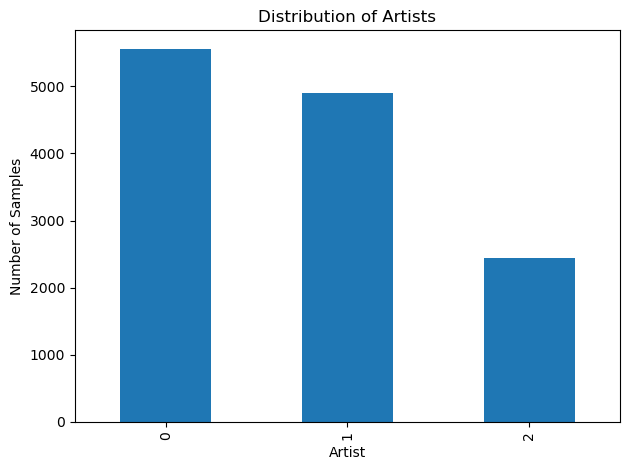

In [7]:
plt.figure()
df["artist"].value_counts().plot(kind="bar")
plt.xlabel("Artist")
plt.ylabel("Number of Samples")
plt.title("Distribution of Artists")
plt.tight_layout()
plt.show()

In [8]:
parts_per_mini = df.groupby("mini").size()

avg_parts = parts_per_mini.mean()
max_parts = parts_per_mini.max()
min_parts = parts_per_mini.min()

print("Average parts per mini:", avg_parts)
print("Max parts for a mini:", max_parts)
print("Min parts for a mini:", min_parts)

Average parts per mini: 5.498293515358362
Max parts for a mini: 61
Min parts for a mini: 1


In [9]:
def is_nan_columns(df):
    nan_rows = None
    if df.isnull().values.any():
        print("Dataset contains NaN values.")
    
        nan_counts = df.isnull().sum()
        print("NaN counts in each column:")
        print(nan_counts[nan_counts > 0])

        print()
        
        nan_rows = df[df.isnull().any(axis=1)]

    return nan_rows

df_nans = is_nan_columns(df)

Dataset contains NaN values.
NaN counts in each column:
weight        1
base_mm    1286
dtype: int64



In [10]:
df.dropna(subset=['weight'], inplace=True)

In [11]:
def preprocess_df(df, features_to_keep, label):
    df['kb']       = df['kb'].astype(int)
    df['volume']   = np.ceil(df['volume'] * 10) / 10

    # Polynomial Features
    df['volume_g'] = df['volume'] * 1e-3 * 1.1
    df['mass_g'] = df['mass']  * 1e-3 * 1.1
    
    # Interaction Features
    df['volume_mass_interaction'] = df['volume_g'] * df['mass_g']
    df['surface_volume_ratio'] = df['surface_area'] / df['volume']
    df['bbox_volume_ratio'] = df['bbox_area'] / df['volume']
    
    # Dimension Ratios
    df['surface_mass_ratio'] = df['surface_area'] / df['mass']
    df['bbox_mass_ratio'] = df['bbox_area'] / df['mass']

    for col in ['surface_area', 'bbox_x', 'bbox_y', 'bbox_z', 'bbox_area', 'weight', 'scale',
                'volume', 'volume_g', 'mass', 'mass_g', 'volume_mass_interaction', 'surface_volume_ratio', 'surface_mass_ratio']:
        df[col] = df[col].round(1)

    df = df[[*features_to_keep, label]]

    return df

label = 'weight'

features = [
    'volume',
    'mass',
    'volume_mass_interaction',
    'surface_volume_ratio',
    'surface_mass_ratio'
]

features_small = [
    'volume',
    'mass',
    'volume_mass_interaction',
    'surface_volume_ratio',
    'surface_mass_ratio'
]

df = preprocess_df(df, features, label)

In [12]:
df.head()

,volume,mass,volume_mass_interaction,surface_volume_ratio,surface_mass_ratio,weight
0,26671.5,26671.5,860.8,2.4,2.4,26.9
1,279.4,279.4,0.1,3.7,3.7,0.2
2,12494.2,12494.2,188.9,2.2,2.2,11.7
3,6960.5,6960.4,58.6,3.2,3.2,6.2
4,3515.4,3515.4,15.0,2.4,2.4,3.6


In [13]:
def plot_feature_distribution_with_bounds(df, feature, q1=0.25, q3=0.85, factor=1.5, bins=100, artist=None):
    col = df[feature]
    Q1 = col.quantile(q1)
    Q3 = col.quantile(q3)
    IQR = Q3 - Q1
    upper_bound = Q3 + factor * IQR

    plt.figure()
    plt.hist(col, bins=bins)
    plt.axvline(upper_bound, linestyle="--")
    plt.xlabel(feature)
    plt.ylabel("count")
    plt.title(f"{feature} distribution with IQR bounds - Artist: {artist}")
    plt.tight_layout()
    plt.show()

    print(f"{feature} Q1={Q1:.3f}, Q3={Q3:.3f}, IQR={IQR:.3f}")
    print(f"Upper Bound:{upper_bound:.3f}")

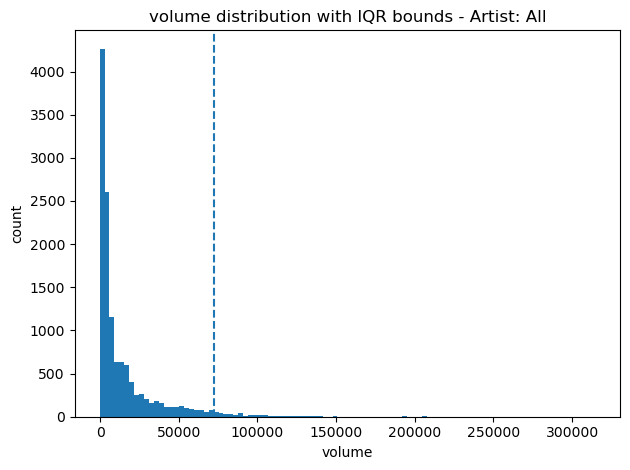

volume Q1=1710.900, Q3=29866.670, IQR=28155.770
Upper Bound:72100.325


In [14]:
plot_feature_distribution_with_bounds(df, feature='volume', artist='All')

In [15]:
def remove_outliers(df, features, q1=0.25, q3=0.85, factor=1.5):
    if isinstance(features, str):
        features = [features]

    cols = df[features]

    Q1 = cols.quantile(q1)
    Q3 = cols.quantile(q3)
    IQR = Q3 - Q1

    upper_bounds = Q3 + factor * IQR

    outlier_flags = cols > upper_bounds
    row_outlier = outlier_flags.any(axis=1)

    mask = ~row_outlier

    print("Upper bounds:")
    print(upper_bounds)
    print(f"→ keeping {mask.sum()} / {len(df)} rows")

    return df[mask]

df = remove_outliers(df, features=['volume'])

Upper bounds:
volume    72100.325
dtype: float64
→ keeping 12479 / 12887 rows


In [16]:
def split_dataset(df, target, test_size, seed, stratified=False, stratified_column=None, num_bins=4):
    tmp = df.copy()

    if stratified and stratified_column:
        tmp["stratified_bins"] = pd.qcut(
            tmp[stratified_column],
            q=num_bins,
            duplicates="drop"
        )
        stratify_col = tmp["stratified_bins"]
    else:
        stratify_col = None

    X = tmp.drop(columns=[target])
    y = tmp[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=seed,
        stratify=stratify_col
    )

    if stratified and stratified_column:
        X_train = X_train.drop(columns=["stratified_bins"])
        X_test = X_test.drop(columns=["stratified_bins"])

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_dataset(df, 'weight', 0.2, SEED, stratified=True, stratified_column='volume')
X_train = np.array(X_train, dtype=np.float32)

In [17]:
def build_and_compile_model(hp, n_features, normalizer):
    model = Sequential()
    model.add(Input(shape=(n_features,)))
    model.add(normalizer)

    init_units = hp.Int("init_units", min_value=384, max_value=768, step=64)
    num_dense_layers = hp.Int("num_dense_layers", min_value=2, max_value=4)

    regularizer = hp.Choice("regularizer", values=["none", "l2"])
    l2_str = hp.Float("l2_str", min_value=1e-6, max_value=7e-5, sampling="log")

    if regularizer == "none":
        kernel_regularizer = None
    else:
        kernel_regularizer = l2(l2_str)

    tested_activations = ["selu", "mish"]

    model.add(Dense(init_units, kernel_regularizer=kernel_regularizer))
    model.add(Activation(hp.Choice("init_activation", values=tested_activations)))

    if hp.Choice("init_batch_normalization", values=[True, False]):
        model.add(BatchNormalization())

    for i in range(num_dense_layers):
        units_i = hp.Int(f"units_{i}", min_value=384, max_value=768, step=64)
        use_bn = hp.Choice(f"batch_normalization_{i}", values=[True, False])

        model.add(Dense(units_i, kernel_regularizer=kernel_regularizer))
        if use_bn:
            model.add(BatchNormalization())

        model.add(Activation(hp.Choice(f"activation_{i}", values=tested_activations)))

        dropout_rate = hp.Choice(f"dropout_{i}", values=[0.0, 0.2, 0.3, 0.4])
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    opt_name = hp.Choice("optimizer", values=["adam", "adamw"])
    learning_rate = hp.Float("learning_rate", min_value=5e-4, max_value=1e-3, sampling="log")

    if opt_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = AdamW(learning_rate=learning_rate)

    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=[MeanAbsoluteError()])
    return model

def search_best_model(project_name, x, y, seed, epochs=50, max_trials=10, split=0.2, batch_size=None, show_model=True):
    n_features = x.shape[1]

    normalizer = Normalization(axis=-1)
    normalizer.adapt(x)

    tuner = kt.BayesianOptimization(
        lambda hp: build_and_compile_model(hp, n_features, normalizer),
        objective=kt.Objective("val_mean_absolute_error", direction="min"),
        max_trials=max_trials,
        directory='bayesian_optimization',
        project_name=project_name,
        seed=seed
    )

    tuner.search(
        x, y,
        epochs=epochs,
        validation_split=split,
        batch_size=batch_size,
        callbacks = CALLBACKS,
    )
    
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model_from_tuner = tuner.hypermodel.build(best_hps)

    if show_model:
        print("Best Model from Tuner:")
        best_model_from_tuner.summary()

    return best_hps, best_model_from_tuner, tuner

def show_best_hps(hps):
    print("Best Hyperparameters:")
    for hp in hps.values:
        print(f"{hp}: {hps.get(hp)}")

In [18]:
best_hps, best_model, tuner = search_best_model('All_Artists', X_train, y_train, epochs=EPOCHS, max_trials=MAX_TRIALS, seed=SEED, batch_size=BATCH_SIZE)
show_best_hps(best_hps)

Trial 50 Complete [00h 00m 28s]
val_mean_absolute_error: 0.5929630994796753

Best val_mean_absolute_error So Far: 0.5088093876838684
Total elapsed time: 00h 16m 51s
Best Model from Tuner:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 5)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 576)            │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 448)            │       258,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 640)            │       287,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 878,028 (3.35 MB)

 Trainable params: 878,017 (3.35 MB)

 Non-trainable params: 11 (48.00 B)

Best Hyperparameters:
init_units: 576
num_dense_layers: 3
regularizer: l2
l2_str: 9.455816627476048e-06
init_activation: mish
init_batch_normalization: 0
units_0: 448
batch_normalization_0: 0
activation_0: selu
dropout_0: 0.2
units_1: 640
batch_normalization_1: 0
activation_1: mish
dropout_1: 0.0
optimizer: adamw
learning_rate: 0.0008056118958976095
units_2: 512
batch_normalization_2: 0
activation_2: mish
dropout_2: 0.0
units_3: 768
batch_normalization_3: 1
activation_3: mish
dropout_3: 0.2


In [19]:
%%time

history = best_model.fit(
    X_train, y_train,
    validation_split=0.3,
    epochs=100,
    callbacks = CALLBACKS,
)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 21.1240 - mean_absolute_error: 2.0580 - val_loss: 3.8233 - val_mean_absolute_error: 0.7368 - learning_rate: 8.0561e-04
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 71.6333 - mean_absolute_error: 1.0250 - val_loss: 3.6511 - val_mean_absolute_error: 0.7204 - learning_rate: 8.0561e-04
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.2115 - mean_absolute_error: 0.9928 - val_loss: 4.3176 - val_mean_absolute_error: 0.8125 - learning_rate: 8.0561e-04
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.3551 - mean_absolute_error: 0.8572 - val_loss: 3.7382 - val_mean_absolute_error: 0.6831 - learning_rate: 8.0561e-04
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.4144 - mean_absolute_error: 0.8285 - val_loss: 3.6215 - val_mean_absolute_error: 0.6909 - learning_rate: 8.0561e-04
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.6743 - mean_absolute_error: 0.8151 

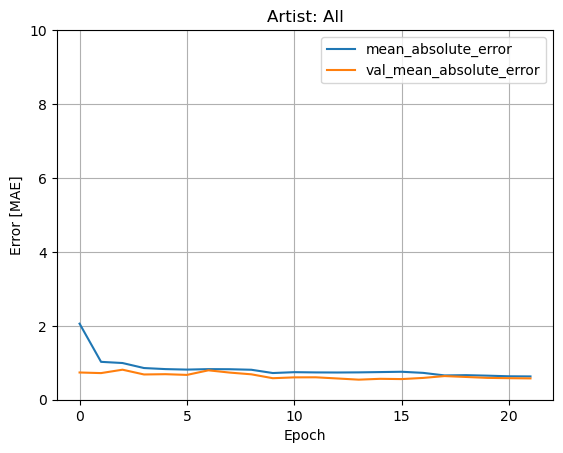

In [20]:
def plot_loss(history, artist=None):
    plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
    plt.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
    plt.ylim([0, 10])
    plt.title(f"Artist: {artist}")
    plt.xlabel('Epoch')
    plt.ylabel('Error [MAE]')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history, 'All')

In [21]:
print('Best All_Artists Model: ', best_model.evaluate(X_test, y_test, verbose=0))

Best All_Artists Model:  [2.6530022621154785, 0.5572737455368042]


In [22]:
predictions = best_model.predict(X_test).flatten()

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


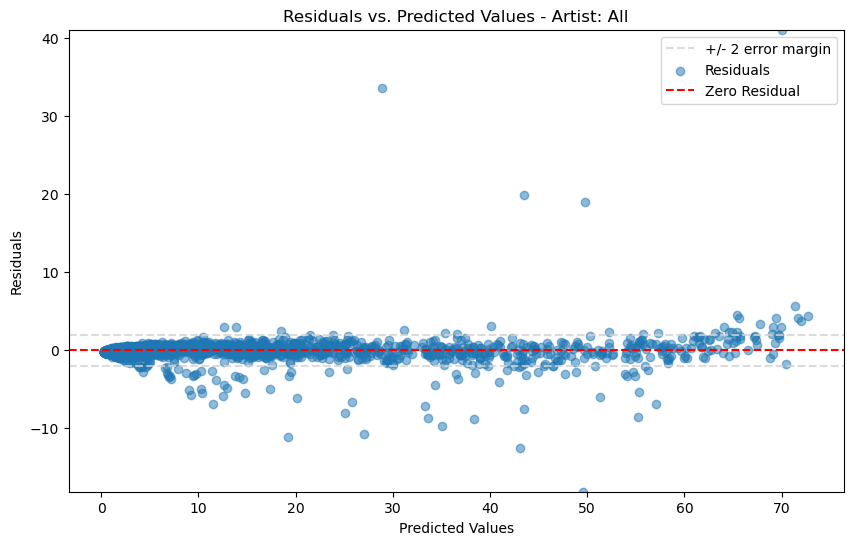

In [23]:
def plot_residuals(y, predictions, error_margin, artist=None):
    residuals = y - predictions.flatten()
    
    plt.figure(figsize=(10, 6))

    plt.axhline(y=error_margin, color='lightgrey', linestyle='--', alpha=0.8, label=f'+/- {error_margin} error margin')
    plt.axhline(y=-error_margin, color='lightgrey', linestyle='--', alpha=0.8)
    
    plt.scatter(predictions, residuals, alpha=0.5, label='Residuals')
    plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
    
    plt.ylim(min(residuals.min(), -error_margin * 1.1), max(residuals.max(), error_margin * 1.1))
    
    plt.title(f'Residuals vs. Predicted Values - Artist: {artist}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

plot_residuals(y_test, predictions, ERROR_MARGIN_G, artist='All')

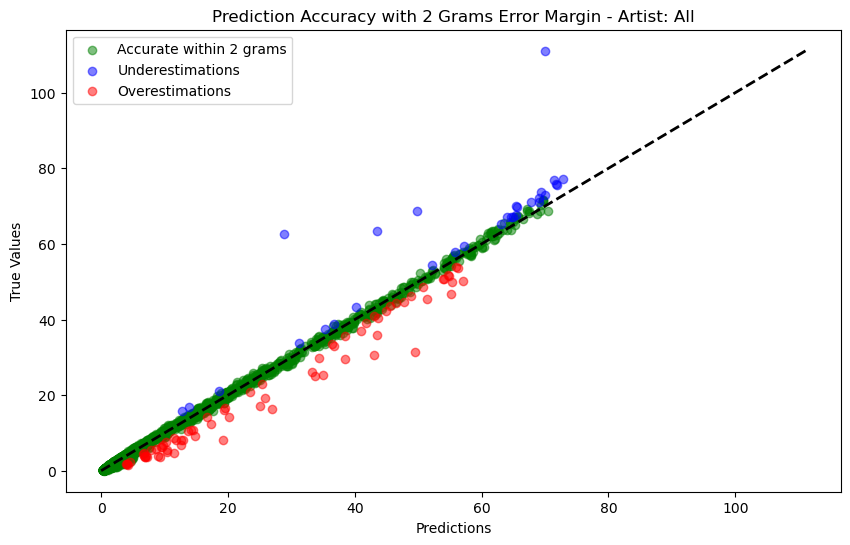

In [24]:
def plot_error_margin(y, predictions, error_margin, artist=None):
    residuals = np.abs(y - predictions)
    accurate_predictions = residuals <= error_margin
    underestimations = (y - predictions) > error_margin
    overestimations = (predictions - y) > error_margin
    
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions[accurate_predictions], y[accurate_predictions], color='green', alpha=0.5, label=f'Accurate within {error_margin} grams')
    plt.scatter(predictions[underestimations], y[underestimations], color='blue', alpha=0.5, label='Underestimations')
    plt.scatter(predictions[overestimations], y[overestimations], color='red', alpha=0.5, label='Overestimations')
    
    plt.xlabel('Predictions')
    plt.ylabel('True Values')
    plt.title(f'Prediction Accuracy with {error_margin} Grams Error Margin - Artist: {artist}')
    plt.legend()
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.show()

plot_error_margin(y_test, predictions, ERROR_MARGIN_G, artist='All')

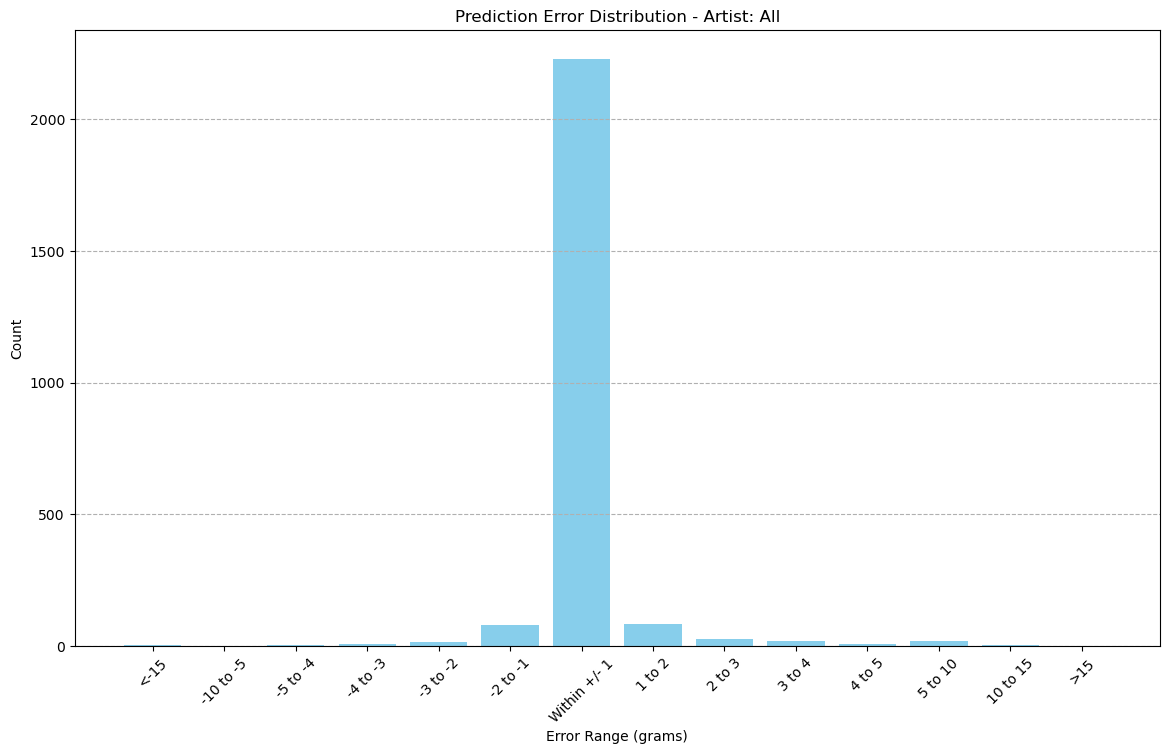

In [25]:
def plot_error_distribution(y_true, y_pred, artist=None):
    differences = y_pred - y_true

    boundaries = [(-np.inf, -15), (-15, -10), (-10, -5), (-5, -4), (-4, -3), (-3, -2), (-2, -1), (-1, 1),
                  (1, 2), (2, 3), (3, 4), (4, 5), (5, 10), (10, 15), (15, np.inf)]
    labels = ['<-15', '-15 to -10', '-10 to -5', '-5 to -4', '-4 to -3', '-3 to -2', '-2 to -1', 
              'Within +/- 1', 
              '1 to 2', '2 to 3', '3 to 4', '4 to 5', '5 to 10', '10 to 15', '>15']
    
    counts = np.zeros(len(labels))
    
    for i, (lower, upper) in enumerate(boundaries):
        if i == 7:  # Special case for 'Within +/- 1'
            counts[i] = np.sum((differences >= lower) & (differences < upper))
        else:
            counts[i] = np.sum((differences > lower) & (differences <= upper))
    
    non_zero_counts = counts > 0
    filtered_labels = np.array(labels)[non_zero_counts]
    filtered_counts = counts[non_zero_counts]

    plt.figure(figsize=(14, 8))
    plt.bar(filtered_labels, filtered_counts, color='skyblue')
    plt.xlabel('Error Range (grams)')
    plt.ylabel('Count')
    plt.title(f'Prediction Error Distribution - Artist: {artist}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--')
    plt.show()

plot_error_distribution(y_test, predictions, artist='All')

In [26]:
df_comparison = pd.DataFrame({'y_test':y_test, 'y_pred': predictions})

In [27]:
def get_results(model_name, predictions, y, error_margin=2, num_predictors=None):
    if num_predictors is None:
        raise ValueError("num_predictors must be provided to calculate adjusted R-squared.")
    
    n = len(y)
    p = num_predictors
    
    absolute_diff = np.abs(predictions - y)
    correct_predictions = np.sum(absolute_diff <= error_margin) / n * 100
    
    rmse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    r_squared = r2_score(y, predictions)
    adjusted_r_squared = 1 - (1-r_squared) * (n-1) / (n-p-1)

    print(f'++++++++ Results for model {model_name} ++++++++\n')
    print(f"Percentage of predictions within {error_margin} grams of the actual values: {correct_predictions}%")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R-squared: {r_squared}")
    print(f"Adjusted R-squared: {adjusted_r_squared}")

    return correct_predictions

class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y, verbose=0)

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        results = self.model.evaluate(X, y, verbose=0)
        # Assuming the first element is the loss
        loss = results[0]
        return -loss

def plot_permutation_importance(model, X_test, y_test, seed, artist=None):
    wrapped_model = KerasRegressorWrapper(model)
    result = permutation_importance(wrapped_model, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=1)
    
    sorted_idx = result.importances_mean.argsort()
    plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
    plt.title(f'Prediction Error Distribution - Artist: {artist}')
    plt.xlabel("Permutation Importance")
    plt.show()

def calculate_differences(y_test, y_pred):
    differences = y_pred - y_test
    
    avg_difference = np.mean(np.abs(differences))
    min_difference = np.min(differences)
    max_difference = np.max(differences)
    
    print(f'Average difference: {avg_difference}, Minimum difference: {min_difference}, Maximum difference: {max_difference}')

def save_model(model, file_path, accuracy):
    if accuracy > 80 and not os.path.exists(file_path):
        model.save(file_path)
        print(f'Model saved as {file_path}')

++++++++ Results for model All_Artist ++++++++

Percentage of predictions within 2 grams of the actual values: 95.83333333333334%
RMSE: 2.6360965240568457
MAE: 0.5572737847001125
R-squared: 0.9898676310248774
Adjusted R-squared: 0.9898472849024375
Average difference: 0.5572737847001125, Minimum difference: -41.046235656738276, Maximum difference: 18.130303955078126


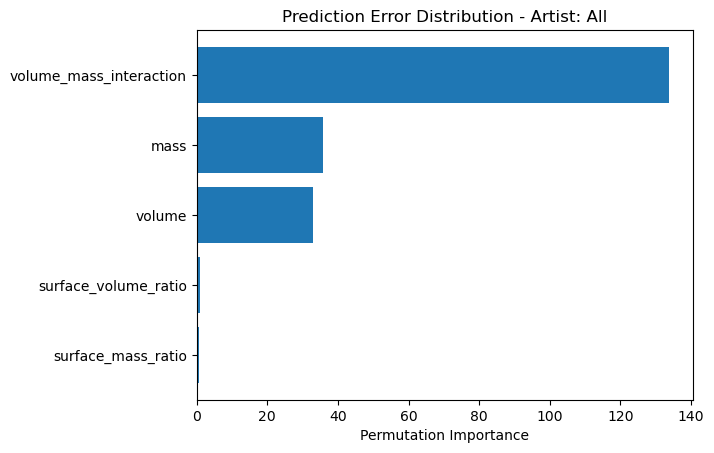

In [28]:
accuracy = get_results('All_Artist', predictions, y_test, error_margin=ERROR_MARGIN_G, num_predictors=best_model.input_shape[1])
calculate_differences(y_test, predictions)
save_model(best_model, f'model_all-{round(accuracy, 3)}.keras', accuracy)
plot_permutation_importance(best_model, X_test, y_test, SEED, artist='All')

In [29]:
def hp_results_to_df(tuner, top_n=None):
    if top_n is None:
        trials = tuner.oracle.trials.values()
    else:
        trials = tuner.oracle.get_best_trials(num_trials=top_n)

    records = []
    for t in trials:
        row = dict(t.hyperparameters.values)  # all hps
        row["score"] = t.score
        records.append(row)
    return pd.DataFrame(records).sort_values('score')

In [30]:
df_hps = hp_results_to_df(tuner)
df_best = hp_results_to_df(tuner, 20)
print(df_hps["score"].isna().sum(), "trials with NaN score")

0 trials with NaN score


In [31]:
df_best

,init_units,num_dense_layers,regularizer,l2_str,init_activation,init_batch_normalization,units_0,batch_normalization_0,activation_0,dropout_0,...,learning_rate,units_2,batch_normalization_2,activation_2,dropout_2,units_3,batch_normalization_3,activation_3,dropout_3,score
0,576,3,l2,0.000009,mish,0,448,0,selu,0.2,...,0.000806,512,0,mish,0.0,768,1,mish,0.2,0.508809
1,576,2,none,0.000008,selu,0,640,1,selu,0.0,...,0.000914,384,0,selu,0.0,704,0,mish,0.4,0.512521
2,448,2,l2,0.000005,selu,0,640,1,selu,0.0,...,0.000693,576,1,mish,0.0,768,1,mish,0.3,0.517985
3,768,2,l2,0.000003,selu,0,768,1,selu,0.4,...,0.000800,576,0,mish,0.0,448,0,selu,0.4,0.549377
4,704,2,l2,0.000002,mish,1,704,0,mish,0.2,...,0.000629,384,0,mish,0.4,704,1,mish,0.0,0.553029
5,576,3,l2,0.000003,selu,1,384,0,selu,0.3,...,0.000999,512,0,mish,0.0,768,0,selu,0.0,0.555852
6,576,3,l2,0.000003,mish,1,768,0,mish,0.3,...,0.000778,384,0,selu,0.3,576,0,selu,0.0,0.582916
7,448,4,none,0.000051,mish,0,704,0,selu,0.0,...,0.000722,512,1,selu,0.3,384,0,mish,0.2,0.583153
8,512,3,l2,0.000010,selu,1,576,1,mish,0.0,...,0.000876,768,1,mish,0.0,704,1,mish,0.0,0.586444
9,448,4,l2,0.000011,selu,1,704,1,mish,0.2,...,0.000572,512,0,selu,0.3,512,0,selu,0.4,0.592963


In [32]:
print(df_best.describe())

       init_units  num_dense_layers     l2_str  init_batch_normalization  \
count   20.000000         20.000000  20.000000                 20.000000   
mean   566.400000          2.900000   0.000012                  0.450000   
std    117.964491          0.788069   0.000013                  0.510418   
min    384.000000          2.000000   0.000001                  0.000000   
25%    496.000000          2.000000   0.000003                  0.000000   
50%    544.000000          3.000000   0.000009                  0.000000   
75%    608.000000          3.250000   0.000012                  1.000000   
max    768.000000          4.000000   0.000051                  1.000000   

          units_0  batch_normalization_0  dropout_0     units_1  \
count   20.000000              20.000000  20.000000   20.000000   
mean   617.600000               0.500000   0.215000  544.000000   
std    121.564538               0.512989   0.159852  110.851252   
min    384.000000               0.000000   0.00

In [33]:
def hyperparam_importance(df_hps, target_col="score"):
    df_clean = df_hps.dropna(subset=[target_col]).copy()

    y = df_clean[target_col]
    X = df_clean.drop(columns=[target_col])

    X = pd.get_dummies(X, drop_first=True)

    X = X.dropna(axis=1, how="any")

    rf = RandomForestRegressor(random_state=0)
    rf.fit(X, y)

    imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    return imp

In [34]:
imp = hyperparam_importance(df_hps)
print(imp.head(20))

l2_str                      0.302664
units_2                     0.166259
units_0                     0.129263
learning_rate               0.058015
dropout_0                   0.041294
batch_normalization_0       0.040606
batch_normalization_2       0.039852
activation_0_selu           0.035063
dropout_1                   0.033003
init_units                  0.032736
num_dense_layers            0.025297
dropout_2                   0.020742
activation_1_selu           0.015213
regularizer_none            0.013410
units_1                     0.013362
init_batch_normalization    0.011093
activation_2_selu           0.005686
init_activation_selu        0.005662
activation_3_selu           0.005048
optimizer_adamw             0.003237
dtype: float64


In [35]:
def _format_sci(x, sig=1):
    """Format x as something like 1e-6 with `sig` significant digits."""
    if x == 0 or not math.isfinite(x):
        return str(x)
    sign = "-" if x < 0 else ""
    x = abs(x)
    exp = int(math.floor(math.log10(x)))
    coeff = round(x / (10 ** exp), sig)
    if coeff >= 10:
        coeff /= 10
        exp += 1
    if sig == 1:
        coeff_str = str(int(coeff))
    else:
        coeff_str = f"{coeff:.{sig-1}f}".rstrip("0").rstrip(".")
    return f"{sign}{coeff_str}e{exp}"

def suggest_hp_ranges(df_hps, target_col="score", higher_is_better=False, top_frac=0.2, q_low=0.1, q_high=0.9, max_categories=3, print_summary=True):
    df = df_hps.dropna(subset=[target_col]).copy()
    df = df.sort_values(target_col, ascending=not higher_is_better)

    n_best = max(1, int(len(df) * top_frac))
    best = df.iloc[:n_best]

    suggestions = {}

    for col in best.columns:
        if col == target_col:
            continue

        series = best[col]
        if pd.api.types.is_numeric_dtype(series):
            lo = float(series.quantile(q_low))
            hi = float(series.quantile(q_high))

            lo_str = str(lo)
            hi_str = str(hi)

            if col == "learning_rate" or col == 'l2_str':
                lo_str = _format_sci(lo)
                hi_str = _format_sci(hi)

            suggestions[col] = {
                "type": "numeric",
                "suggested_min": lo,
                "suggested_max": hi,
                "suggested_min_str": lo_str,
                "suggested_max_str": hi_str,
            }
        else:
            vc = series.value_counts()
            top_vals = list(vc.index[:max_categories])
            suggestions[col] = {
                "type": "categorical",
                "suggested_values": top_vals,
            }

    if print_summary:
        for hp, info in suggestions.items():
            if info["type"] == "numeric":
                print(
                    f"{hp} → "
                    f"{info['suggested_min_str']} .. {info['suggested_max_str']} "
                    f"(raw: {info['suggested_min']}, {info['suggested_max']})"
                )
            else:
                print(f"{hp} → {info['suggested_values']}")

    return suggestions

In [36]:
ranges = suggest_hp_ranges(df_hps, target_col="score", higher_is_better=False)

init_units → 448.0 .. 710.4 (raw: 448.0, 710.4)
num_dense_layers → 2.0 .. 4.0 (raw: 2.0, 4.0)
regularizer → ['l2', 'none']
l2_str → 2e-6 .. 1e-5 (raw: 2.4959992817885963e-06, 1.513293306963768e-05)
init_activation → ['selu', 'mish']
init_batch_normalization → 0.0 .. 1.0 (raw: 0.0, 1.0)
units_0 → 441.6 .. 768.0 (raw: 441.6, 768.0)
batch_normalization_0 → 0.0 .. 1.0 (raw: 0.0, 1.0)
activation_0 → ['selu', 'mish']
dropout_0 → 0.0 .. 0.30999999999999994 (raw: 0.0, 0.30999999999999994)
units_1 → 448.0 .. 710.4 (raw: 448.0, 710.4)
batch_normalization_1 → 0.0 .. 1.0 (raw: 0.0, 1.0)
activation_1 → ['mish', 'selu']
dropout_1 → 0.0 .. 0.4 (raw: 0.0, 0.4)
optimizer → ['adam', 'adamw']
learning_rate → 6e-4 .. 9e-4 (raw: 0.0006231783500611937, 0.0009225836851989772)
units_2 → 384.0 .. 595.1999999999999 (raw: 384.0, 595.1999999999999)
batch_normalization_2 → 0.0 .. 1.0 (raw: 0.0, 1.0)
activation_2 → ['mish', 'selu']
dropout_2 → 0.0 .. 0.30999999999999994 (raw: 0.0, 0.30999999999999994)
units_3 → 441